In [1]:
import sys
sys.path.append("../src")

import jax
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(500)

import jax.numpy as jnp
from nn import MLP, train
import numpy as np
import matplotlib.pyplot as plt
import optax 
import scipy
from functools import partial
from path_sampling import dfdt, div_f, update_non_amortized
from path_sampling import make_double_well_potential, sample_sde


## Example of Algorithm 1: with $b$ as Brownian Bridge drift

This is an example of a transport from Brownian bridge to Posteior.


In [2]:

potential = make_double_well_potential(v=5.0)

def uref(x, t): 
    return -jax.grad(potential)(x)


s:  0.0
Train loss: 1922802.75
i:  0
s:  0.0
Train loss: 39707468.0
i:  1
s:  0.1
Train loss: 140.5287322998047
i:  2
s:  0.2
Train loss: 166.03170776367188
i:  3
s:  0.30000000000000004
Train loss: 141.52618408203125
i:  4
s:  0.4
Train loss: 137.32167053222656
i:  5
s:  0.5
Train loss: 118.51786804199219
i:  6
s:  0.6000000000000001
Train loss: 95.1937026977539
i:  7
s:  0.7000000000000001
Train loss: 75.99089813232422
i:  8
s:  0.8
Train loss: 69.64433288574219
i:  9
s:  0.9
Train loss: 70.46707153320312
i:  10


Text(0, 0.5, 'Time')

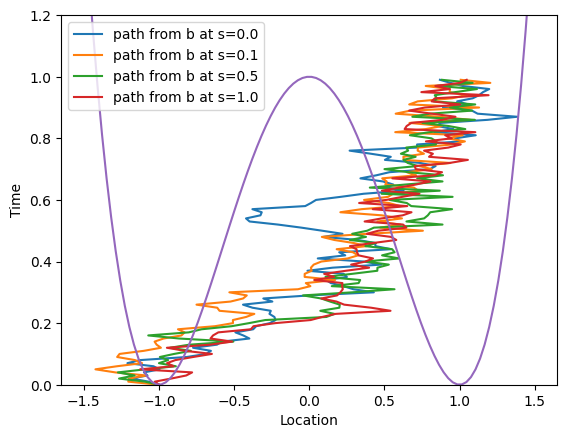

In [5]:
key = jax.random.key(0)

hyperparams = {'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 1000, 'batch_size' : 250}

brownian_bridge_drift = lambda x,t: (1.0 - x)/(1-t)

ndims = 1


# likelihood function
def make_J_brownian_bridge(dt, V):
    def J_brownian_bridge(x, y):
        nabla_V = jax.grad(V)
        laplacian_of_potential = jax.vmap(lambda k: jnp.trace(jax.jacfwd(nabla_V)(k)))(x)
        return 0.5*jnp.sum(jax.vmap(lambda xt, dv : dt*(0.5*nabla_V(xt).dot(nabla_V(xt)) - dv) )(x, laplacian_of_potential))
    return J_brownian_bridge


key = jax.random.key(0)

# b = uref # initialize b as uref
schedule = np.linspace(0,1,11) 
# schedule = [0.1,0.5,1.0]

rho = lambda key: jnp.zeros((ndims,))-1.   #initialization
W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,))
 
V = make_double_well_potential(v=5.0)
b = brownian_bridge_drift
A_TH = 0

for i, s in enumerate(schedule):

    key = jax.random.fold_in(key, i)

    nn_key, run_key = jax.random.split(key)
    dbds = MLP([3,30,20,10,1], key=nn_key)

    b, A = update_non_amortized(
        V=V,   # not used with SPDE off
        b=b,   # prior drift
        J=make_J_brownian_bridge(hyperparams['dt'], V),
        prior='brownian',
        dbds=dbds,
        hyperparams=hyperparams,
        key=run_key,
        schedule=schedule,
        i=i,
        A_TH=A_TH,
        refine=False,
        plotted_times=[0,1,5,10]
        
        
    )

potential = make_double_well_potential(v=1.0)
x = jnp.expand_dims(jnp.linspace(-1.5, 1.5, 100), 1)
y = potential(x)
# limit y axis to 5
plt.ylim(0, 1.2)
plt.plot(x, y)
plt.xlabel('Location')
plt.ylabel('Time')  


## Rerun with SPDE turned on

s:  0.0
Train loss: 3519064.5
i:  0
s:  0.0
Train loss: 1176429.75
i:  1
s:  0.1
Train loss: 2265.31103515625
i:  2
s:  0.2
Train loss: 1244.9876708984375
i:  3
s:  0.30000000000000004
Train loss: 1573.2275390625
i:  4
s:  0.4
Train loss: 839.5311889648438
i:  5
s:  0.5
Train loss: 796.3121948242188
i:  6
s:  0.6000000000000001
Train loss: 581.9515991210938
i:  7
s:  0.7000000000000001
Train loss: 670.2507934570312
i:  8
s:  0.8
Train loss: 463.3621520996094
i:  9
s:  0.9
Train loss: 369.62579345703125
i:  10


Text(0, 0.5, 'Time')

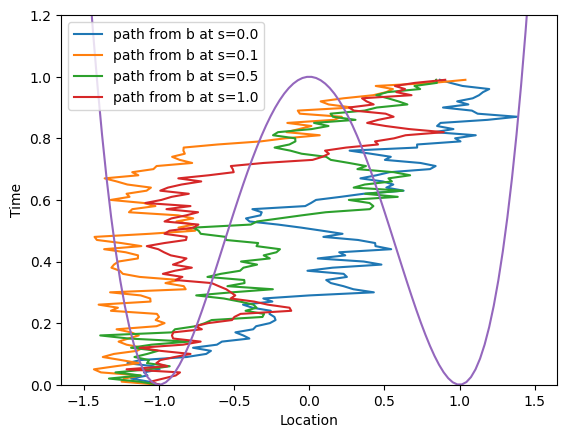

In [6]:
key = jax.random.key(0)

hyperparams = {'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 1000, 'batch_size' :250}

brownian_bridge_drift = lambda x,t: (1.0 - x)/(1-t)

ndims = 1


# likelihood function
def make_J_brownian_bridge(dt, V):
    def J_brownian_bridge(x, y):
        nabla_V = jax.grad(V)
        laplacian_of_potential = jax.vmap(lambda k: jnp.trace(jax.jacfwd(nabla_V)(k)))(x)
        return 0.5*jnp.sum(jax.vmap(lambda xt, dv : dt*(0.5*nabla_V(xt).dot(nabla_V(xt)) - dv) )(x, laplacian_of_potential))
    return J_brownian_bridge


key = jax.random.key(0)

# b = uref # initialize b as uref
schedule = np.linspace(0,1,11) 
# schedule = [0.1,0.5,1.0]

rho = lambda key: jnp.zeros((ndims,))-1.   #initialization
W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,))
 
    
V = make_double_well_potential(v=5.0)   # V is the double-well potential
b = brownian_bridge_drift
A_TH = 0

for i, s in enumerate(schedule):

    key = jax.random.fold_in(key, i)

    nn_key, run_key = jax.random.split(key)
    dbds = MLP([3,30,20,10,1], key=nn_key)

    b, A = update_non_amortized(
        V=lambda x: s*V(x),   # this is used in SPDE (it's scaled by s since we are gradually introducing the potential) 
        b=b,   # prior drift
        J=make_J_brownian_bridge(hyperparams['dt'], V),
        prior='brownian',
        dbds=dbds,
        hyperparams=hyperparams,
        key=run_key,
        schedule=schedule,
        i=i,
        A_TH=A_TH,
        refine=True,
        plotted_times=[0,1,5,10]
    )

# plot double well potential
potential = make_double_well_potential(v=1.0)
x = jnp.expand_dims(jnp.linspace(-1.5, 1.5, 100), 1)
y = potential(x)
# limit y axis to 5
plt.ylim(0, 1.2)
plt.plot(x, y)
plt.xlabel('Location')
plt.ylabel('Time')
